In [66]:
# Проверка работоспособности системы
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
print(tf.__version__)

# Проверка подключения графического процессора
print("Доступные устройства GPU:")
for device in tf.config.experimental.list_physical_devices():
    print(device)

os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

2.15.0
Доступные устройства GPU:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


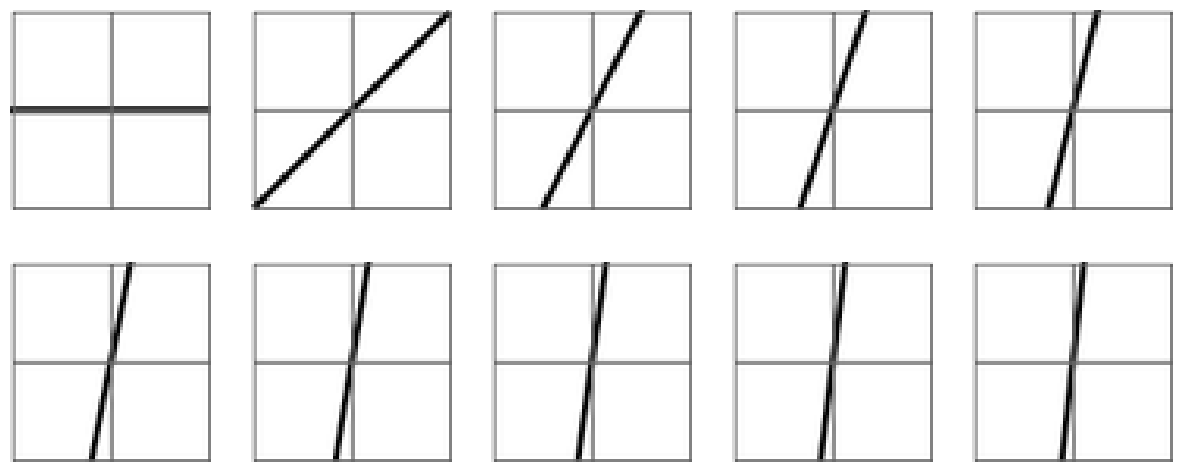

In [70]:
### Просмотр файлов папки датасета ###

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def show_image_gallery(images, cols=2):
    n_images = len(images)
    nrows = (n_images + cols - 1) // cols  # Calculate rows needed
    
    fig, axes = plt.subplots(nrows, cols, figsize=(15, nrows * 3))
    for i, ax in enumerate(axes.flat):
        if i < n_images:
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

# Путь к папке с изображениями
folder_path = "C:\\WORK_DIRECTORY\\7_СЕМ\\Курсовая работа 7 сем\\TF_регрессия\\datasets\\dataset_1\\train"
images = load_images_from_folder(folder_path)

show_image_gallery(images, cols=5)

In [72]:
### Создание датасета из файлов ###

# Создание датасета для обучения

# Функции загрузки и предобработки к каждому элементу датасета
def load_and_preprocess_train_image(image_path, label):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_png(img, channels=1)  # Черно-белые изображения
        img = tf.image.resize(img, [64, 64])
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img, label

# Функция, которая создает датасет из папки с изображениями
def import_train_data(image_dir):
    # Получение списка файлов с изображениями
    image_files = []
    # for papka in os.listdir(image_dir):
    #     papka_dir = image_dir + '/' + papka
    #     for file in os.listdir(papka_dir):
    #         if file.endswith('.png'):
    #             image_files.append(os.path.join(papka_dir, file))
    
    for file in os.listdir(image_dir):
            if file.endswith('.png'):
                image_files.append(os.path.join(image_dir, file))

   
    print("Количество изображений:",len(image_files))
   
    # Создание списка меток 
    labels = []
    dict_labels = dict()
    for i in range(0, len(image_files)):
         # Создание индекса графика
        label = int(image_files[i].split(".png")[0].split("\\")[1])
        labels.append(i)
        dict_labels[label] = i

    print(dict_labels)
    print("Количество меток:",len(set(labels)))
    print("Распределение меток:",labels)

    # Создание датасета с использованием tf.data.Dataset.from_tensor_slices
    dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
    
    # Применение функции загрузки и предобработки к каждому элементу датасета
    dataset = dataset.map(load_and_preprocess_train_image)
    
    return dataset, dict_labels, len(dict_labels)


# Путь к папке с изображениями для обучения
train_image_dir = "C:/WORK_DIRECTORY/7_СЕМ/Курсовая работа 7 сем/TF_регрессия/datasets/dataset_1/train"



train_dataset, train_kodificator, output_classes = import_train_data(train_image_dir)

batch_size = 1  # Количество изображений подаваемых нейросети за одну итерацию обучения
train_dataset = train_dataset.batch(batch_size)
print("Кодификатор: ", train_kodificator)
print("Длина кодификатора: ", len(train_kodificator))
print("Количество классов: ", output_classes)



Количество изображений: 10
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
Количество меток: 10
Распределение меток: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Кодификатор:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
Длина кодификатора:  10
Количество классов:  10


In [73]:
### СОЗДАНИЕ МОДЕЛИ СЕТИ ### 

from tensorflow.keras import layers, models
# Определим параметры входного изображения
input_shape = (64, 64, 1)  # 64x64 пикселя, 3 канала (RGB)

# Создание модели
model = models.Sequential()

# Преобразование изображения в плоский вектор
model.add(layers.Flatten(input_shape=input_shape))

# Добавление полносвязного слоя
model.add(layers.Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mse')

# Вывод структуры модели
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 4097 (16.00 KB)
Trainable params: 4097 (16.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
### ОБУЧЕНИЕ СЕТИ ###

# Определение пути для сохранения модели
checkpoint_filepath = 'best_model.h5'

# Настройка коллбека ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,         # путь для сохранения модели
    monitor='val_loss',                   # метрика для мониторинга (здесь - валидационная функция потерь)
    save_best_only=True,                  # сохранять только лучшую модель
    save_weights_only=False,              # сохранять не только веса, но и всю модель
    mode='min',                           # искать минимальное значение метрики
    verbose=1                             # выводить информацию о сохранении
)

history = model.fit(train_dataset,
                    epochs=500, 
                    batch_size=1,
                    validation_data=train_dataset,
                    callbacks=[checkpoint])


Epoch 1/500
 1/10 [==>...........................] - ETA: 5s - loss: 60184.6250
Epoch 1: val_loss improved from inf to 7644.15723, saving model to best_model.h5
10/10 [==============================] - 1s 27ms/step - loss: 130074.9141 - val_loss: 7644.1572
Epoch 2/500
 1/10 [==>...........................] - ETA: 0s - loss: 16840.9121
Epoch 2: val_loss improved from 7644.15723 to 3152.62085, saving model to best_model.h5
10/10 [==============================] - 0s 11ms/step - loss: 24894.4336 - val_loss: 3152.6208
Epoch 3/500
 1/10 [==>...........................] - ETA: 0s - loss: 177.5311
Epoch 3: val_loss improved from 3152.62085 to 1524.03943, saving model to best_model.h5
10/10 [==============================] - 0s 13ms/step - loss: 7839.1187 - val_loss: 1524.0394
Epoch 4/500
 1/10 [==>...........................] - ETA: 0s - loss: 3381.5691
Epoch 4: val_loss did not improve from 1524.03943
10/10 [==============================] - 0s 11ms/step - loss: 2210.0149 - val_loss: 10115.0

In [75]:

test_loss = model.evaluate(train_dataset)
print ('Значение функции потерь:', test_loss)

new_model = tf.keras.models.load_model('best_model.h5')
test_loss = new_model.evaluate(train_dataset)
print ('Значение функции потерь:', test_loss)


10/10 [==============================] - 0s 2ms/step - loss: 4.4455
Значение функции потерь: 4.445538520812988
10/10 [==============================] - 0s 3ms/step - loss: 0.8733
Значение функции потерь: 0.87328040599823


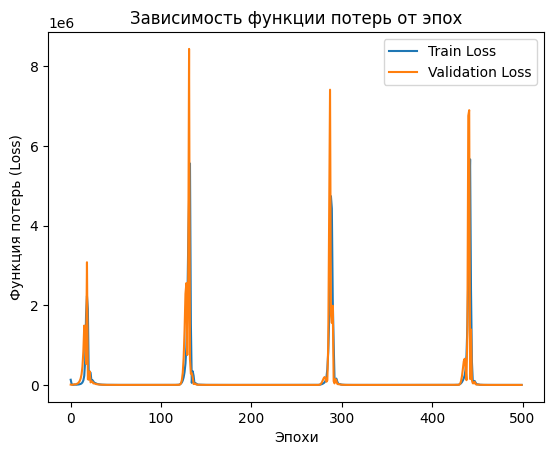

In [76]:
# Построение графика функции потерь
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Зависимость функции потерь от эпох')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь (Loss)')
plt.legend()
plt.show()

In [78]:
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)  # Черно-белые изображения
    img = tf.image.resize(img, [64, 64])
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.expand_dims(img, axis=0)  # Создание батча из одного изображения
    return img

# Пример пути к новому изображению
img_path = "C:/WORK_DIRECTORY/7_СЕМ/Курсовая работа 7 сем/TF_регрессия/datasets/dataset_1/"

for i in range(10):
    img = load_and_preprocess_image(img_path + str(i) + ".png")
    predictions = new_model.predict(img)
    print("Img ", i, "->", predictions)


1/1 [==============================] - 0s 36ms/step
Img  0 -> [[-0.04010458]]
1/1 [==============================] - 0s 86ms/step
Img  1 -> [[0.8439997]]
1/1 [==============================] - 0s 60ms/step
Img  2 -> [[1.8823999]]
1/1 [==============================] - 0s 33ms/step
Img  3 -> [[2.8232007]]
1/1 [==============================] - 0s 36ms/step
Img  4 -> [[4.500573]]
1/1 [==============================] - 0s 28ms/step
Img  5 -> [[3.716247]]
1/1 [==============================] - 0s 32ms/step
Img  6 -> [[7.768215]]
1/1 [==============================] - 0s 36ms/step
Img  7 -> [[5.458417]]
1/1 [==============================] - 0s 32ms/step
Img  8 -> [[8.97562]]
1/1 [==============================] - 0s 37ms/step
Img  9 -> [[8.444771]]


In [87]:
img_path = "C:/WORK_DIRECTORY/7_СЕМ/Курсовая работа 7 сем/TF_регрессия/datasets/dataset_1/test/9.5.png"
img = load_and_preprocess_image(img_path)
predictions = new_model.predict(img)
print(predictions)

1/1 [==============================] - 0s 29ms/step
[[9.355982]]


In [93]:
img_path = "C:/WORK_DIRECTORY/7_СЕМ/Курсовая работа 7 сем/TF_регрессия/datasets/dataset_1/train/9.png"
img = load_and_preprocess_image(img_path)
predictions = new_model.predict(img)
print(predictions)

1/1 [==============================] - 0s 32ms/step
[[8.444771]]
